In [1]:
# import necessary packages

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [2]:
# read effort estimation data

china = pd.read_csv('datasets/china.csv')
chinaOriginal = pd.read_csv('datasets/chinaOriginal.csv')
cocomo_nasa = pd.read_csv('datasets/cocomo-nasa.csv')
desharnais = pd.read_csv('datasets/desharnais.csv')

In [3]:
china = china.drop(['id'], axis=1)
china = china.copy()

In [4]:
china.tail()

,AFP,Input,Output,Enquiry,File,Interface,Added,Changed,Deleted,Resource,Duration,DevType,AdjFactor,Effort
494,51,32,0,16,7,0,0,55,0,1,3.0,Maint,0.927273,899
495,1106,410,267,108,152,25,962,0,0,2,20.0,NewDev,1.149688,16560
496,99,13,32,3,42,5,95,0,0,1,4.0,NewDev,1.042105,526
497,56,24,0,9,14,0,47,0,0,2,6.0,NewDev,1.191489,440
498,213,123,91,28,0,0,36,206,0,1,7.0,Maint,0.880165,2185


In [5]:
# clean the data

china.isna().sum()

AFP          0
Input        0
Output       0
Enquiry      0
File         0
Interface    0
Added        0
Changed      0
Deleted      0
Resource     0
Duration     0
DevType      0
AdjFactor    0
Effort       0
dtype: int64

In [6]:
china['DevType'] = china['DevType'].map(lambda x: {'Maint': 'Maint', 'NewDev': 'NewDev'}.get(x))

In [7]:
china = pd.get_dummies(china, prefix='', prefix_sep='')
china.tail()

,AFP,Input,Output,Enquiry,File,Interface,Added,Changed,Deleted,Resource,Duration,AdjFactor,Effort,Maint,NewDev
494,51,32,0,16,7,0,0,55,0,1,3.0,0.927273,899,1,0
495,1106,410,267,108,152,25,962,0,0,2,20.0,1.149688,16560,0,1
496,99,13,32,3,42,5,95,0,0,1,4.0,1.042105,526,0,1
497,56,24,0,9,14,0,47,0,0,2,6.0,1.191489,440,0,1
498,213,123,91,28,0,0,36,206,0,1,7.0,0.880165,2185,1,0


In [8]:
# Split the data into train and test

china_train_dataset = china.sample(frac=0.8, random_state=0)
china_test_dataset = china.drop(china_train_dataset.index)

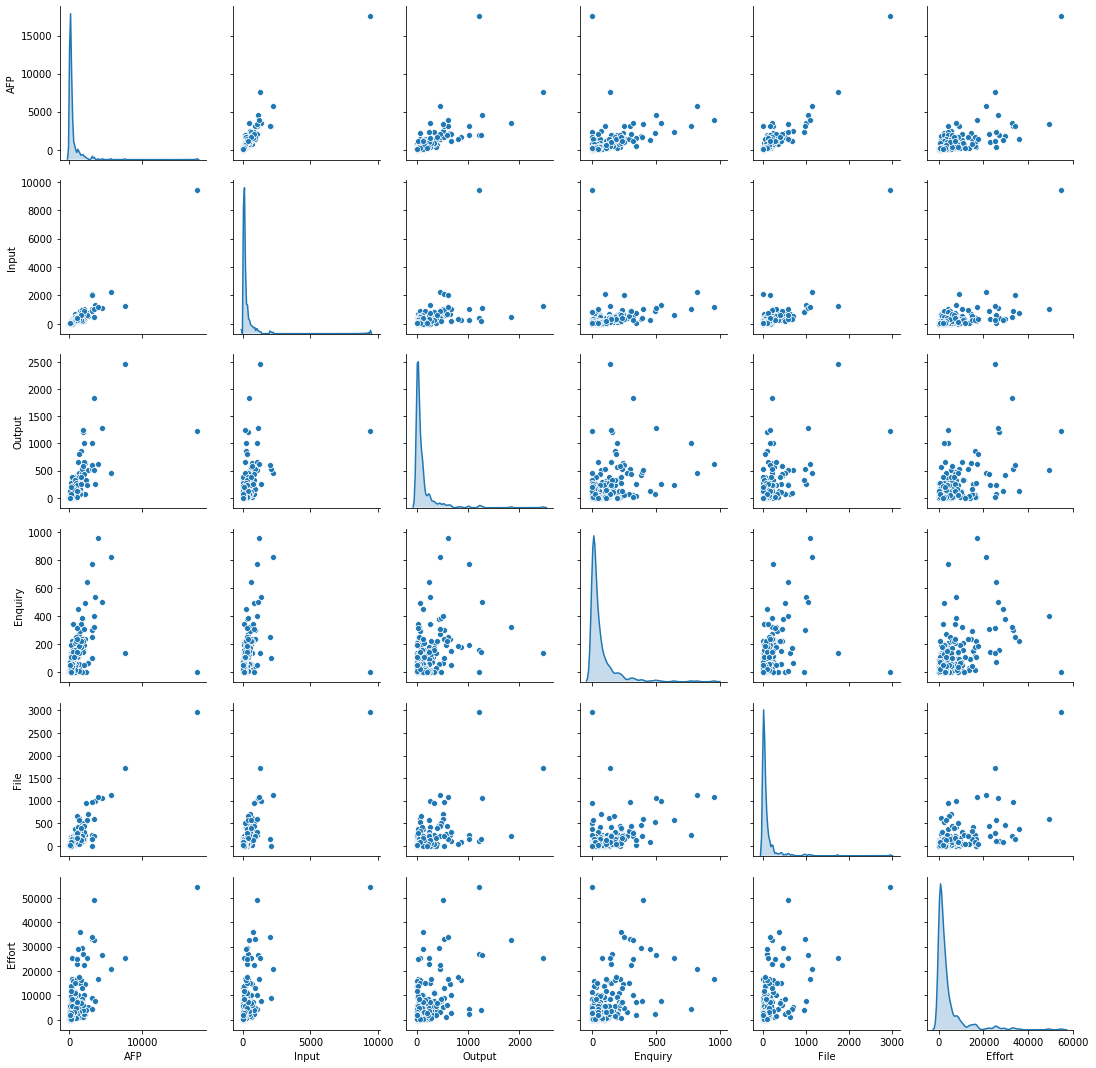

In [9]:
# Inspect the data

sns.pairplot(china_train_dataset[["AFP", "Input", "Output", "Enquiry", "File", "Effort"]], diag_kind="kde")

In [10]:
# Also look at the overall statistics

china_train_stats = china_train_dataset.describe()
china_train_stats.pop("Effort")
china_train_stats = china_train_stats.transpose()
china_train_stats

,count,mean,std,min,25%,50%,75%,max
AFP,399.0,529.814536,1164.737176,12.000000,102.500000,224.000000,465.000000,17518.000000
Input,399.0,186.180451,538.828818,0.000000,27.000000,70.000000,166.500000,9404.000000
Output,399.0,121.333333,239.460410,0.000000,14.000000,42.000000,116.500000,2455.000000
Enquiry,399.0,65.889724,113.470572,0.000000,6.000000,25.000000,72.500000,952.000000
File,399.0,100.511278,230.342577,0.000000,14.000000,39.000000,90.000000,2955.000000
Interface,399.0,24.388471,90.746053,0.000000,0.000000,0.000000,20.000000,1572.000000
Added,399.0,397.982456,911.836788,0.000000,39.000000,141.000000,347.500000,13580.000000
Changed,399.0,85.694236,314.329895,0.000000,0.000000,3.000000,82.500000,5193.000000
Deleted,399.0,14.626566,138.658227,0.000000,0.000000,0.000000,0.000000,2657.000000
Resource,399.0,1.466165,0.843678,1.000000,1.000000,1.000000,2.000000,4.000000


In [11]:
# Split features from labels

china_train_labels = china_train_dataset.pop('Effort')
china_test_labels = china_test_dataset.pop('Effort')

In [12]:
# normalize the data

def norm(x):
  return (x - china_train_stats['mean']) / china_train_stats['std']
normed_china_train_data = norm(china_train_dataset)
normed_china_test_data = norm(china_test_dataset)

In [13]:
# build the model

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(china_train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________


In [16]:
# try out the model

china_example_batch = normed_china_train_data[:15]
china_example_result = model.predict(china_example_batch)
china_example_result

array([[-0.13811435],
       [ 0.01572213],
       [-0.07266431],
       [-0.01620808],
       [-0.15520537],
       [-0.1341977 ],
       [-0.21098456],
       [-0.12859204],
       [-0.03914941],
       [-0.1687719 ],
       [-0.06425874],
       [-0.03937258],
       [-0.18865874],
       [-0.14403431],
       [-0.18307248]], dtype=float32)

In [17]:
# train the model

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1200

history = model.fit(
  normed_china_train_data,
  china_train_labels,
  epochs=EPOCHS,
  validation_split = 0.2,
  verbose=0,
  callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [18]:
# Visualize the model's training progress

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
1195,1.535296e+07,2133.705811,15352965.0,20406752.6,2744.285889,20406752.0,1195
1196,1.530139e+07,2128.149902,15301393.0,20393880.0,2745.958496,20393880.0,1196
1197,1.535225e+07,2135.133545,15352248.0,20393475.2,2745.757568,20393476.0,1197
1198,1.531429e+07,2128.159424,15314284.0,20384653.6,2748.080322,20384652.0,1198
1199,1.534165e+07,2133.426270,15341650.0,20387436.8,2747.935791,20387436.0,1199


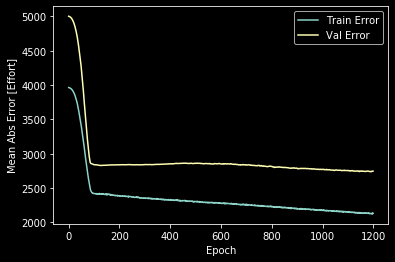

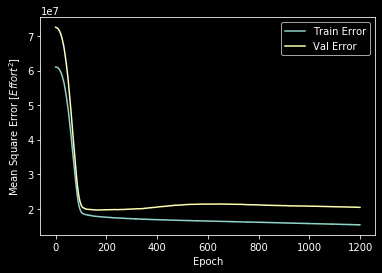

In [19]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.style.use('dark_background')
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Effort]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Effort^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)


....................................................................................................
.................................................

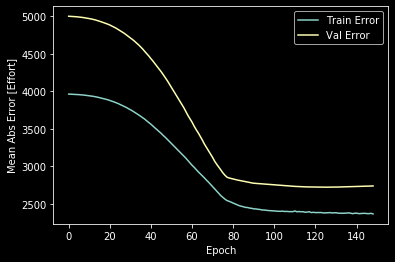

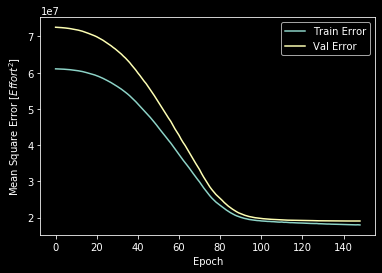

In [20]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_china_train_data, china_train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [21]:
loss, mae, mse = model.evaluate(normed_china_test_data, china_test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Effort".format(mae))

100/100 - 0s - loss: 16024935.1600 - mae: 2102.8528 - mse: 16024936.0000
Testing set Mean Abs Error: 2102.85 Effort


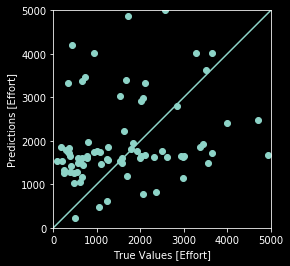

In [22]:
# make predictions

test_predictions = model.predict(normed_china_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(china_test_labels, test_predictions)
plt.xlabel('True Values [Effort]')
plt.ylabel('Predictions [Effort]')
lims = [0, 5000]
plt.xlim(lims)
plt.ylim(lims)
plt.style.use('dark_background')
_ = plt.plot(lims, lims)

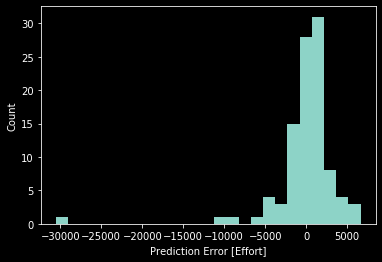

In [23]:
# error distribution

error = test_predictions - china_test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Effort]")
plt.style.use('dark_background')
_ = plt.ylabel("Count")